In [9]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('/NEURD_Chenlab')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
"""
Show the general pipeline used for the GNN models used for cell typing
in the neuron and limb based models referenced in the NEURD paper. This 
tutorial shows how to use the models for inference runs. 
"""

'\nShow the general pipeline used for the GNN models used for cell typing\nin the neuron and limb based models referenced in the NEURD paper. This \ntutorial shows how to use the models for inference runs. \n'

# Installing Dependencies

In [11]:
# !pip3 install torch-scatter -f https://data.pyg.org/whl/torch-1.10.2+cpu.html
# !pip3 install torch-sparse -f https://data.pyg.org/whl/torch-1.10.2+cpu.html
# !pip3 install torch-geometric

# Model Training Background Information

In [12]:
"""
Standard training 
of GNN models using pytorch geometric was used with the following hyper parameters

Neuron Model
------------
1) lr = 0.0001
2) label_weights = {
     '23P': 0.8,
     '4P': 0.5,
     '5P-IT': 1,
     '5P-NP': 1,
     '5P-PT': 1,
     '6P-CT': 0.8,
     '6P-IT': 1,
     'BC': 1,
     'BPC': 1,
     'MC': 1,
     'NGC': 1
    }
3) Dropout (0.5)
4) torch.optim.Adam optimizer
5) batch_size = 64
6) 60/20/20 train/validation/test split

Limb Model
----------
1) lr = 0.001 ** only learning hyper parameter that is different **
2) label_weights = {
     '23P': 0.8,
     '4P': 0.5,
     '5P-IT': 1,
     '5P-NP': 1,
     '5P-PT': 1,
     '6P-CT': 0.8,
     '6P-IT': 1,
     'BC': 1,
     'BPC': 1,
     'MC': 1,
     'NGC': 1
    }
3) Dropout (0.5)
4) torch.optim.Adam optimizer
5) batch_size = 64
6) 60/20/20 train/validation/test split

Note: training 
"""
""

''

# Step 0: Accessing ground truth data

In [13]:
"""
Can get ground truth cell typing labels from the caveclient
"""

'\nCan get ground truth cell typing labels from the caveclient\n'

In [27]:
from neurd.vdi_microns_cave import volume_data_interface as vdi

from neurd.vdi_microns import volume_data_interface as vdi # <-- from old tutorials, not sure of the difference between vdi_microns_cave vs vdi_microns


In [23]:
"""
The minnie public api wasn't working at the time of development so we
pulled down the public cell typing table ahead of time and now
just need to load it locally
"""

"\nThe minnie public api wasn't working at the time of development so we\npulled down the public cell typing table ahead of time and now\njust need to load it locally\n"

In [29]:
from datasci_tools import pandas_utils as pu
df_labels = pu.csv_to_df("./training_data/public_cave_ground_truth_cell_types_with_nucleus.csv")

print(df_labels.shape)

df_labels


(1357, 3)


,segment_id,nucleus_id,cell_type
0,864691136021936376,258319,23P
1,864691136487559186,276438,6P-CT
2,864691135784109363,260552,23P
3,864691135694415551,260263,23P
4,864691135759892302,262898,BPC
...,...,...,...
1352,864691135503182685,267029,5P-PT
1353,864691136335150259,267294,5P-PT
1354,864691135688186080,303145,5P-PT
1355,864691135503435613,302955,5P-PT


In [41]:
# search for particular segment ID

segment_id = 864691135567721964   # original segment ID was 
first_col = df_labels.iloc[:,0].values  # This will get the first row as a pandas Series

# Check if the unique number exists in the first row
if segment_id in first_col:
    print(f'Found unique number {unique_number} in the first col!')
else:
    print(f'Unique number {unique_number} not found in the first col')

Unique number 864691135567721964 not found in the first col.


## how to pull down the mesh for a segment id

In [39]:
segment_id = '864691135567721964'

mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

mesh filepath is 864691135567721964.off


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(451453, 3), faces.shape=(899885, 3), name=`864691135567721964.off`)>

In [40]:
result = df_labels.query(f"segment_id == {segment_id}")
print(result)

y = df_labels.query(f"segment_id == {segment_id}")['cell_type'].to_list()[0]
y

Empty DataFrame
Columns: [segment_id, nucleus_id, cell_type]
Index: []


IndexError: list index out of range

In [12]:
from datasci_tools import ipyvolume_utils as ipvu

ipvu.plot_objects(mesh)

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

## Decomposition

In [13]:
"""
Would then just decompose using the given tutorials to get the 
neuron objects to be used in the GNN classification

Example: NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc
"""

'\nWould then just decompose using the given tutorials to get the \nneuron objects to be used in the GNN classification\n\nExample: NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc\n'

## ** If want output to completely match those the pretrained models were developed with then need to compute spine volume with convex hull

In [42]:
from mesh_tools import trimesh_utils as tu

tu.mesh_volume_old = tu.mesh_volume
def new_mesh_volume_func(*args,**kwargs):
    kwargs["watertight_method"] = "convex_hull"
    return tu.mesh_volume_old(
        *args,
        **kwargs
    )

tu.mesh_volume = new_mesh_volume_func

# Step 0: Pulling Data Previously Computed

In [44]:
from neurd import neuron_utils as nru
from neuron_morphology_tools import neuron_nx_utils as nxu


In [58]:
# Initially: exc_neuron_obj = "../Auto_Proof_Pipeline/Single_Soma_Exc/864691134917511946_auto_proof.pbz2"   <-- may need to use this one
# specify absolute paths for ease of use
exc_neuron_obj = "/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/864691134917511946_auto_proof.pbz2"  
exc_neuron_mesh = "/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/864691134917511946.off"
exc_cell_type = "5P-IT"

neuron_obj_exc = nru.decompress_neuron(
    exc_neuron_obj,
    original_mesh=exc_neuron_mesh
)
neuron_obj_exc

Decompressing Neuron in minimal output mode...please wait


In [55]:
inh_neuron_obj = "/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Inh/864691135567721964.pbz2"
inh_neuron_mesh = "/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Inh/864691135567721964.off"
inh_cell_type = "MC"

neuron_obj_inh = nru.decompress_neuron(
    inh_neuron_obj,
    original_mesh=inh_neuron_mesh
)
neuron_obj_inh

Decompressing Neuron in minimal output mode...please wait


AttributeError: Can't get attribute '_PrimitiveAttributes' on <module 'trimesh.primitives' from '/usr/local/lib/python3.8/dist-packages/trimesh/primitives.py'>

In [59]:
G_exc = neuron_obj_exc.neuron_graph_after_proof
G_exc

In [19]:
G_inh = neuron_obj_inh.neuron_graph_after_proof
G_inh

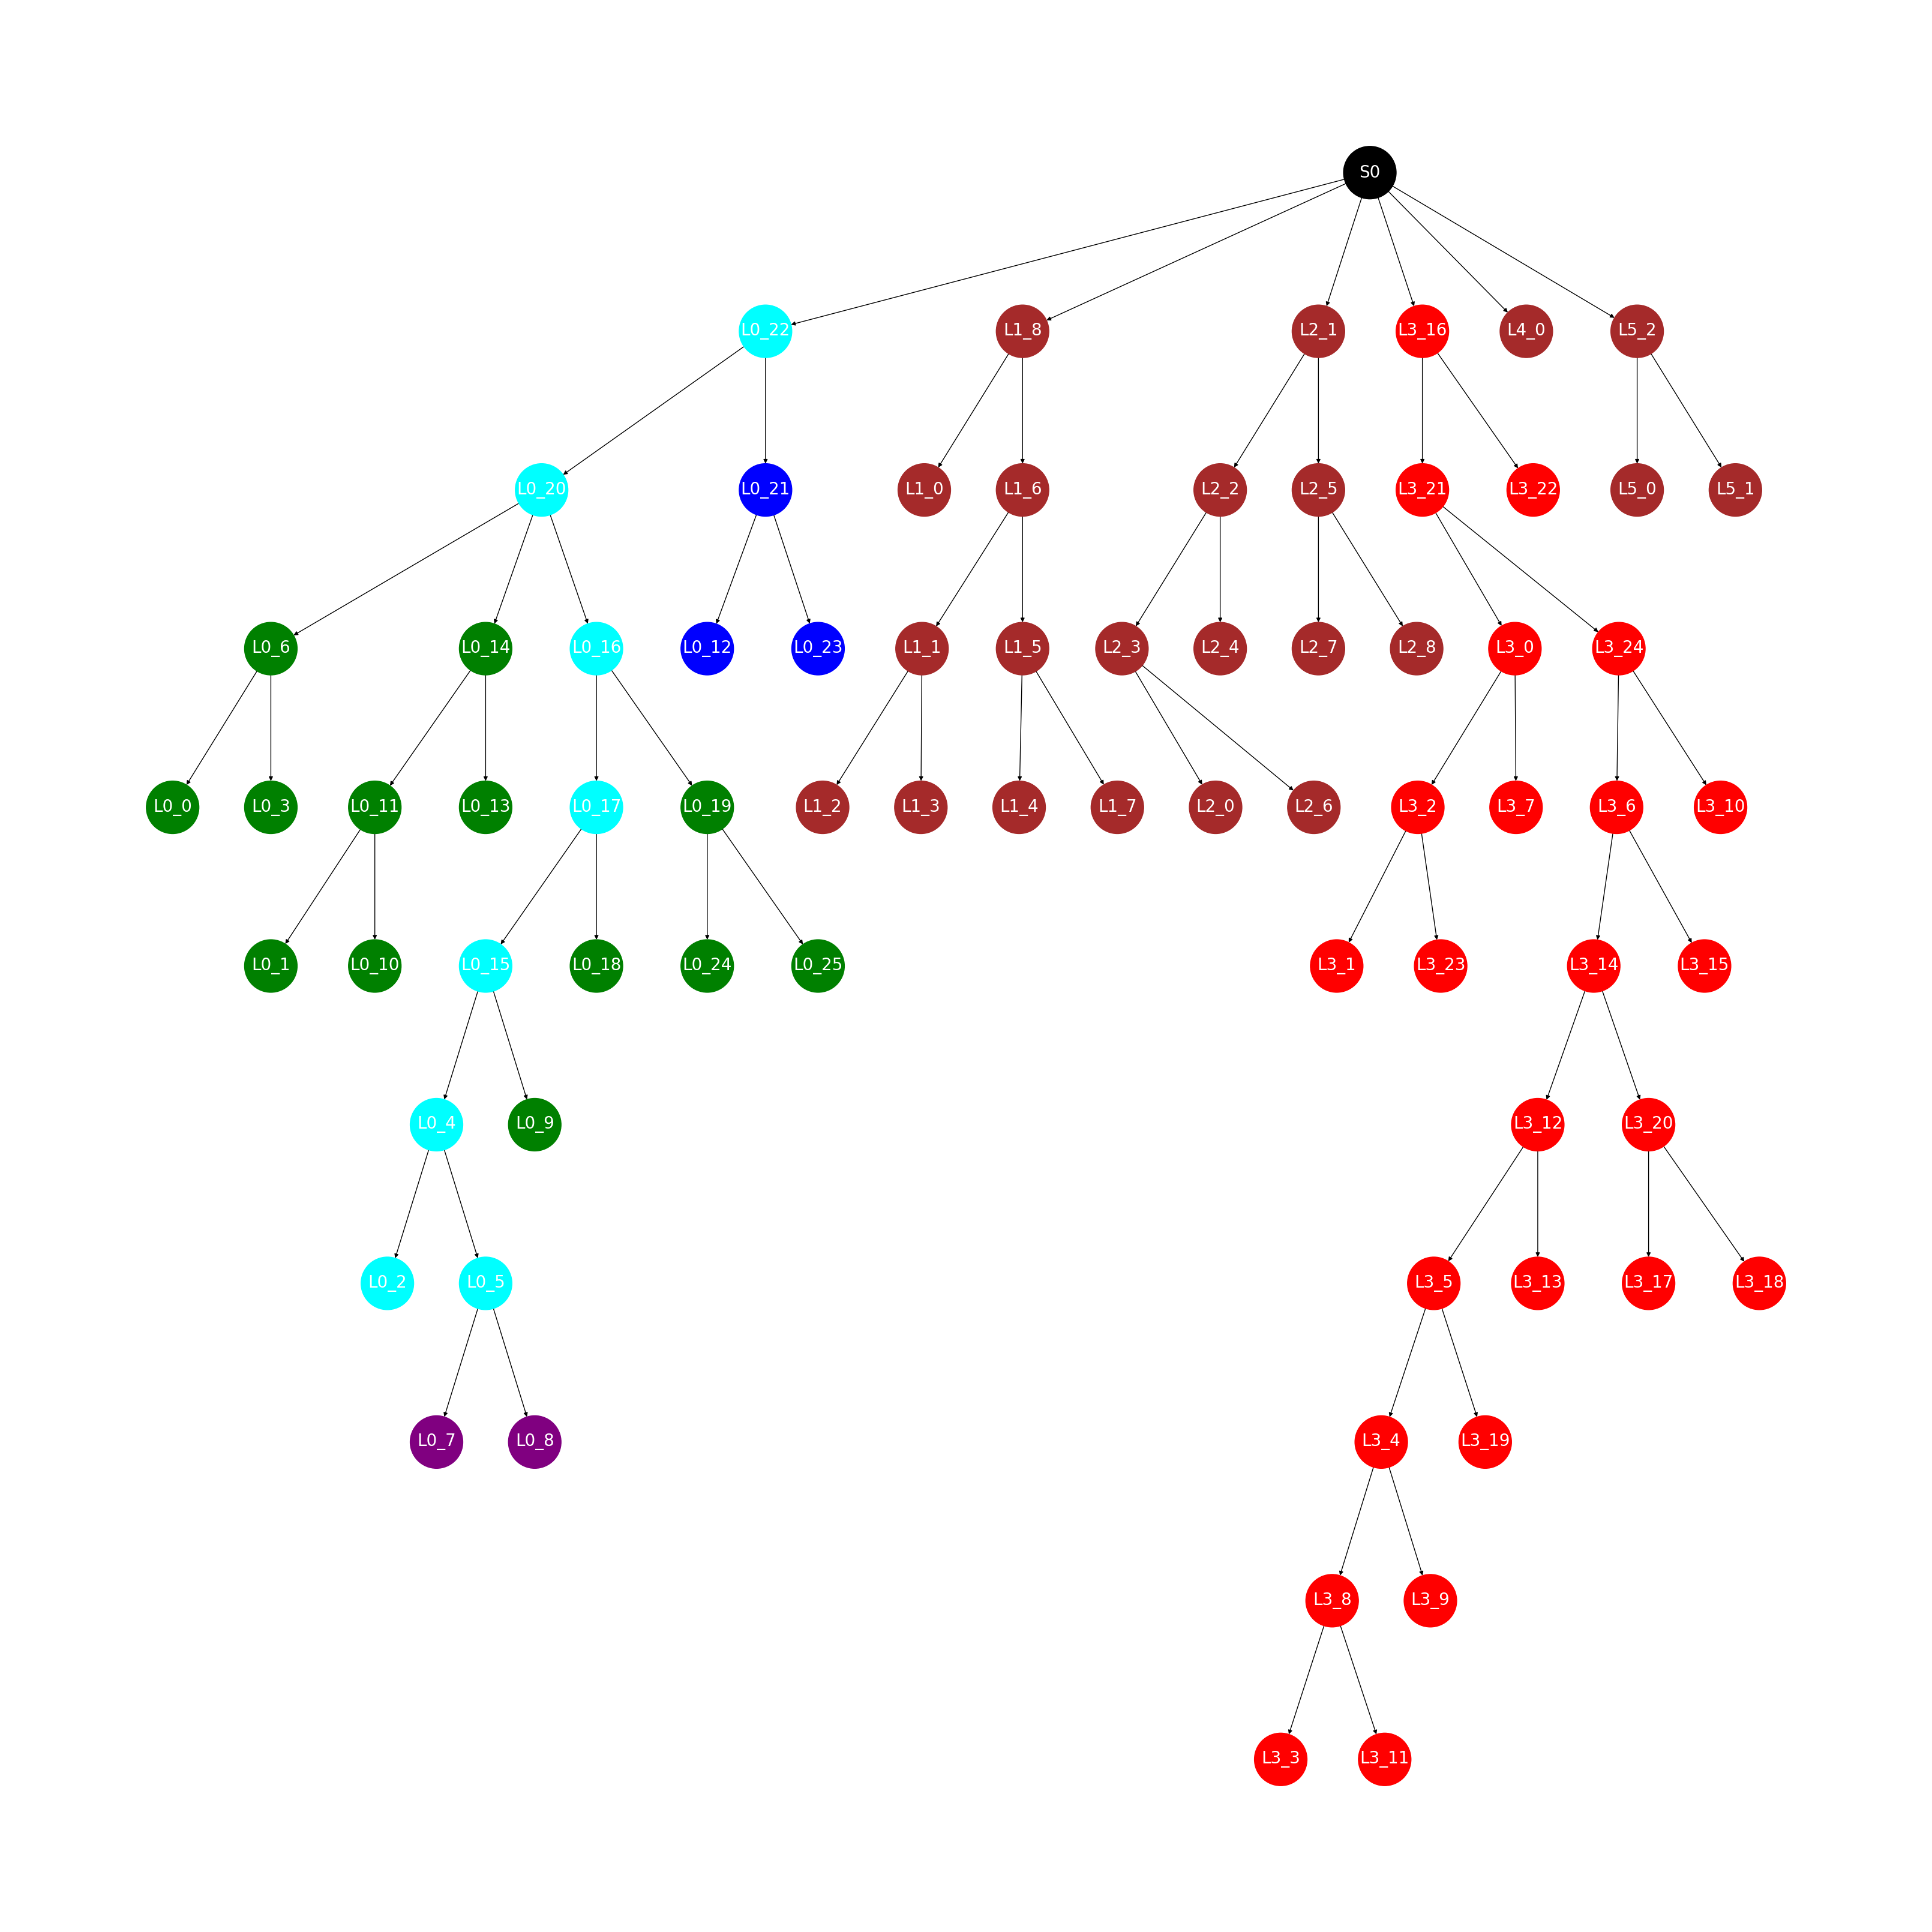

In [60]:
nxu.draw_tree(G_exc)

In [ ]:
nxu.draw_tree(G_inh)

# Step 1: Transforming networkx graphs into dataset objects (that can be easily converted to pytorch geometric dataset objects)

In [69]:
from neurd.gnn_cell_typing_utils import NeuronGraphData,OutputClassConfig
from neurd import gnn_cell_typing_utils as gnnu

In [22]:
Gs = [
    (G_exc,exc_cell_type),
    (G_inh,inh_cell_type),
]

In [23]:
# converting networkx graphs into dataset objects
G_data = [NeuronGraphData(k,label=v) for k,v in Gs]
Gd = G_data[0]
Gd

Neuron 864691134917511946_None (Nodes = 47, Edges = 84, Features = 24)

In [24]:
# deciding whether to use full neurons or limbs of neurons as graph data

# full neurons as instances
graph_data_list_neuron = G_data

#neuron limbs as instances
graph_data_list_limbs = [limb_G for neurons in G_data for limb_G in neurons.limb_data_objs]

# Step 2: Converting dataset objects to pytorch dataset objects

## a) Loading the normalization mean/std

In [25]:
from datasci_tools import pandas_utils as pu
df_norm_filepath = "./models/neuron_feature_normalization.csv"
df_norm = pu.csv_to_df(df_norm_filepath)
df_norm

,skeletal_length,skeleton_vector_upstream_theta,skeleton_vector_upstream_phi,skeleton_vector_downstream_theta,skeleton_vector_downstream_phi,width_upstream,width_no_spine,width_downstream,n_synapses_post,n_synapses_pre,...,synapse_volume_shaft_postsyn_sum,synapse_volume_head_postsyn_sum,synapse_volume_no_head_postsyn_sum,synapse_volume_neck_postsyn_sum,synapse_volume_postsyn_sum,n_spines,spine_volume_sum,soma_start_angle_max,max_soma_volume,n_syn_soma
0,55516.345178,1.589076,-0.157227,1.589966,-0.157332,403.639852,365.678239,371.095051,54.578176,0.360460,...,182354.026566,163152.136975,47041.102496,2391.117333,394938.383371,25.560443,5.539396e+09,73.452389,1164.384624,85.420511
1,50351.743964,0.683233,1.839419,0.680496,1.829458,177.472687,163.786514,207.490286,55.187287,1.039375,...,216697.807828,198671.208494,70791.367719,6358.946166,398733.480809,30.177752,7.103286e+09,47.322576,618.928943,64.757569


## b) Creating the class mapping

In [26]:
class_config = OutputClassConfig(gnnu.microns_cell_type_map)
class_config

{'23P': 0, '4P': 1, '5P-IT': 2, '5P-NP': 3, '5P-PT': 4, '6P-CT': 5, '6P-IT': 6, 'BC': 7, 'BPC': 8, 'MC': 9, 'NGC': 10}

## c) Creating Pytorch Datasets

In [28]:
from neurd.gnn_cell_typing_utils import NeuronDataset

torch_data_obj_neuron = NeuronDataset(
    graph_data_list_neuron,
    normalization_df=df_norm,
    class_config = class_config,
)
# the pytorch geometric dataset 
torch_data_obj_neuron.dataset

[Data(x=[47, 24], edge_index=[2, 84], y=2, node_weight=[47], segment_id=864691134917511946),
 Data(x=[57, 24], edge_index=[2, 100], y=9, node_weight=[57], segment_id=864691135567721964)]

In [30]:
torch_data_obj_limb = NeuronDataset(
    graph_data_list_limbs,
    normalization_df=df_norm,
    class_config = class_config,
)

# the pytorch geometric dataset 
torch_data_obj_limb.dataset

[Data(x=[25, 24], edge_index=[2, 48], y=2, node_weight=[25], segment_id=864691134917511946, limb_idx=0),
 Data(x=[9, 24], edge_index=[2, 16], y=2, node_weight=[9], segment_id=864691134917511946, limb_idx=1),
 Data(x=[9, 24], edge_index=[2, 16], y=2, node_weight=[9], segment_id=864691134917511946, limb_idx=2),
 Data(x=[1, 24], edge_index=[2, 0], y=2, node_weight=[1], segment_id=864691134917511946, limb_idx=3),
 Data(x=[3, 24], edge_index=[2, 4], y=2, node_weight=[3], segment_id=864691134917511946, limb_idx=4),
 Data(x=[3, 24], edge_index=[2, 4], y=9, node_weight=[3], segment_id=864691135567721964, limb_idx=0),
 Data(x=[9, 24], edge_index=[2, 16], y=9, node_weight=[9], segment_id=864691135567721964, limb_idx=1),
 Data(x=[15, 24], edge_index=[2, 28], y=9, node_weight=[15], segment_id=864691135567721964, limb_idx=2),
 Data(x=[13, 24], edge_index=[2, 24], y=9, node_weight=[13], segment_id=864691135567721964, limb_idx=3),
 Data(x=[11, 24], edge_index=[2, 20], y=9, node_weight=[11], segment_i

## d) Creating a dataloader

# Step 3: Loading the Model and running inference

In [31]:
batch_size = 20

## Option 1: Neuron Based Model

### a) Instantiating model

In [32]:
model_architecture_kwargs = architecture_kwargs = dict(
    num_node_features = torch_data_obj_neuron.dataset[0].x.shape[1],
    num_classes = class_config.num_classes,
    activation_function = "relu",
    global_pool_type="mean_weighted",
    global_pool_weight = "node_weight",
    
    n_hidden_channels=128,
    n_layers = 2,
    
    #batch norm specifics
    use_bn = True,
    track_running_stats=True,
)

model = gnnu.NeuronGCN(**architecture_kwargs)
model_weights = "./models/neuron_gnn_2_layer"

neuron_input_obj = gnnu.GnnInput(
    dataset_obj = torch_data_obj_neuron,
    model = model,
    model_weights_filepath = model_weights,
    class_config = class_config,
)

neuron_input_obj.model

NeuronGCN(
  (conv0_pool0): GCNConv(24, 128)
  (bn0_pool0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_pool0): GCNConv(128, 128)
  (bn1_pool0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=128, out_features=11, bias=True)
)

### b) Inference Run

In [33]:
inf_obj = gnnu.InferenceRunner(neuron_input_obj)
inf_obj.run()

In [34]:
inf_obj.prediction_df

,graph_idx,y_pred_class,y_pred_confidence,y_true
0,0,5P-IT,0.519212,5P-IT
1,1,MC,0.998454,MC


## Option 2: Limb Based Model

### a) Instantiating model

In [35]:
architecture_kwargs_limb = dict(
    num_node_features = torch_data_obj_limb.dataset[0].x.shape[1],
    num_classes = class_config.num_classes,
    activation_function = "relu",
    global_pool_type="mean_weighted",
    global_pool_weight = "node_weight",
    
    n_hidden_channels=128,
    n_layers = 2,
    
    #batch norm specifics
    use_bn = True,
    track_running_stats=True,
)

model_limb = gnnu.LimbGCN(**architecture_kwargs_limb)
model_weights_limb = "./models/limb_gnn_2_layer"

limb_input_obj = gnnu.GnnInput(
    dataset_obj = torch_data_obj_limb,
    model = model_limb,
    model_weights_filepath = model_weights_limb,
    class_config = class_config,
)

limb_input_obj.model

LimbGCN(
  (conv0_pool0): GCNConv(24, 128)
  (bn0_pool0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_pool0): GCNConv(128, 128)
  (bn1_pool0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=256, out_features=11, bias=True)
)

### b) Inference Run

In [36]:
inf_obj_limb = gnnu.InferenceRunner(limb_input_obj)
inf_obj_limb.run()

In [37]:
"""
Note: if neuron objects were not run with 
spine volume computed using a convex hull then some limbs
may not be as accurate
"""

inf_obj_limb.prediction_df

,graph_idx,y_pred_class,y_pred_confidence,y_true
0,0,6P-CT,0.973951,5P-IT
1,1,6P-CT,0.773135,5P-IT
2,2,23P,0.882425,5P-IT
3,3,4P,0.160657,5P-IT
4,4,6P-IT,0.557298,5P-IT
5,5,BC,0.999383,MC
6,6,BC,0.912832,MC
7,7,MC,0.861699,MC
8,8,BPC,0.648130,MC
9,9,MC,0.679721,MC


In [ ]:
"""
Note: the limb based model is lower performing becuase the 
newer neuron graph objects were generating using mesh volume 
computed using a higher fidelity method of mesh repair
whereas the limb model was based on data where the mesh
volume was computed using a convex hull. This fact along
with the usage of max pooling in the limb based model
is what makes this feature more likely to degrade the 
classification accuracy. To avoid this you could train 
your own limb based model or when computing the neuron
object set the  mesh volume function to use a convex
hull as mentioned earlier
"""